In [2]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
%%capture
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

In [9]:
# Set Working Directory
import os

os.chdir('/nfs/turbo/umms-efeldman/mnoureld/LPS_ST')
print(os.getcwd())

/nfs/turbo/umms-efeldman/mnoureld/LPS_ST


In [10]:
# Read ST file
adata = sc.read_visium('/nfs/turbo/umms-efeldman/globus/AGC/4973-JH/10x_analysis_4973-JH/Sample_4973-JH-S2-A_GCACTGAG-TTCACGCA')
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

reading /nfs/turbo/umms-efeldman/globus/AGC/4973-JH/10x_analysis_4973-JH/Sample_4973-JH-S2-A_GCACTGAG-TTCACGCA/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [17]:
adata

AnnData object with n_obs × n_vars = 2124 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

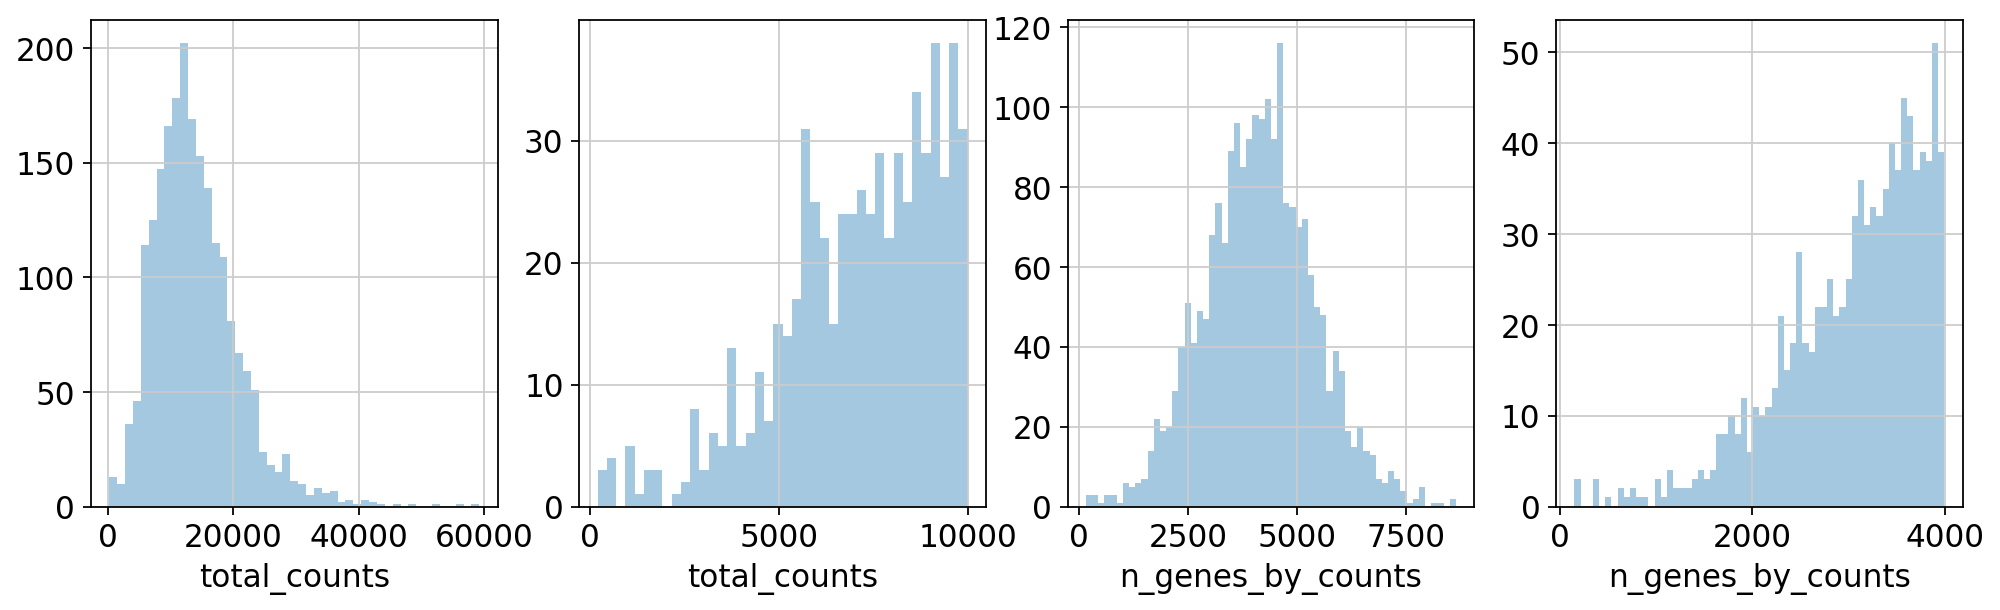

In [16]:
# Inspect basic QC matrics
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

In [18]:
# Filter your adata object
sc.pp.filter_cells(adata, min_counts=5000)
sc.pp.filter_cells(adata, max_counts=35000)
adata = adata[adata.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

filtered out 98 cells that have less than 5000 counts
filtered out 24 cells that have more than 35000 counts
#cells after MT filter: 2002
filtered out 16639 genes that are detected in less than 10 cells


Trying to set attribute `.var` of view, copying.


In [21]:
# Normalization
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [23]:
!pip3 install leidenalg

Defaulting to user installation because normal site-packages is not writeable


In [24]:
# UMAP
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
running Leiden clustering
    finished: found 14 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


... storing 'feature_types' as categorical
... storing 'genome' as categorical


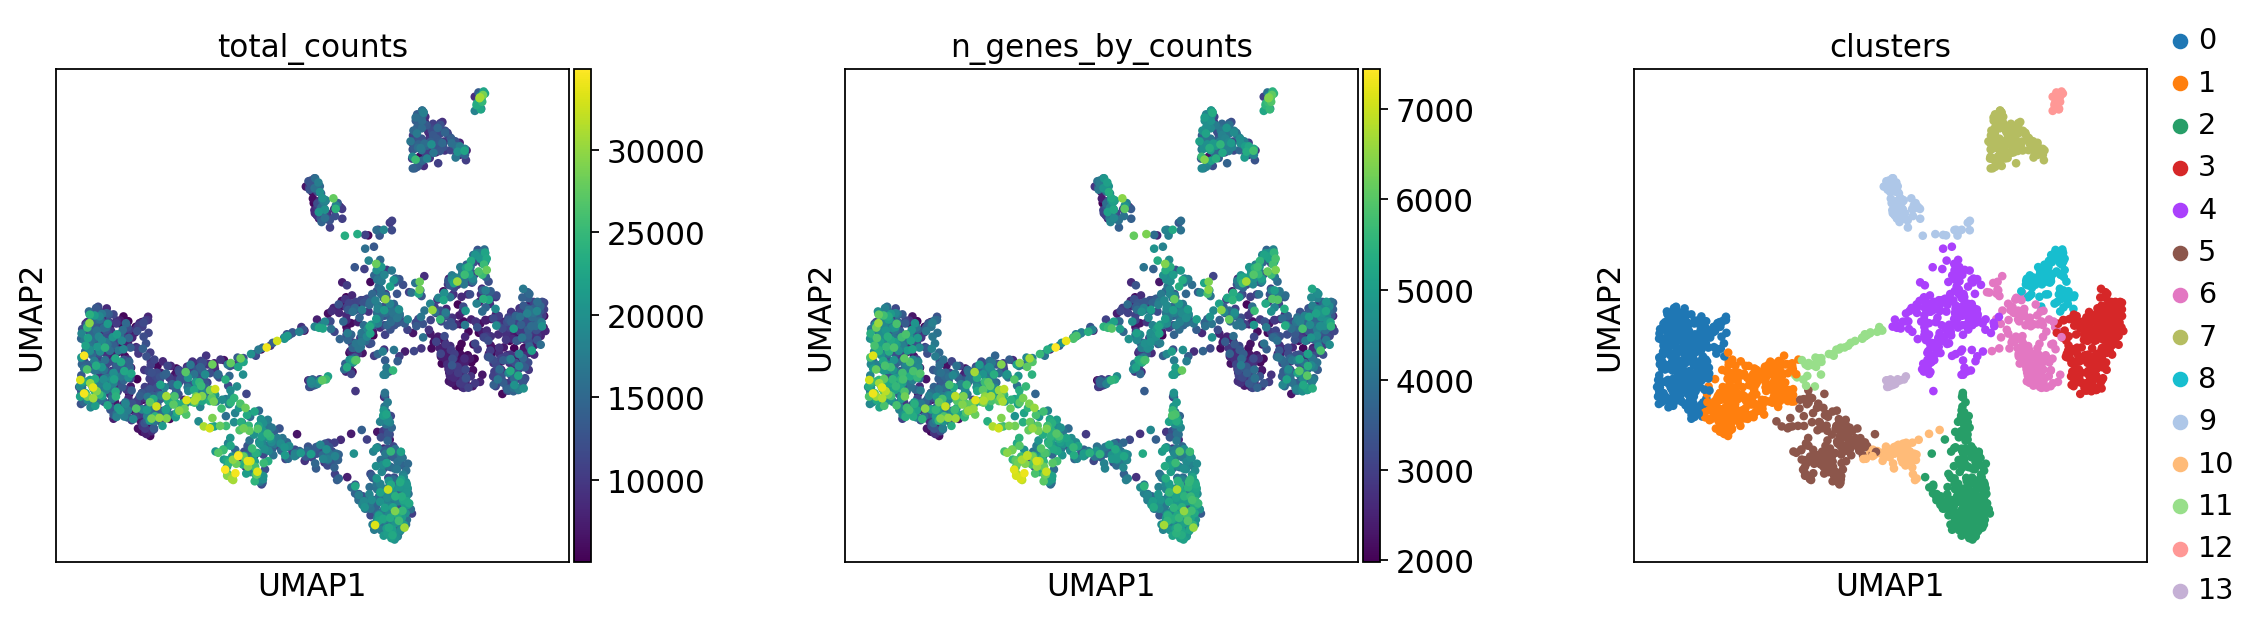

In [25]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

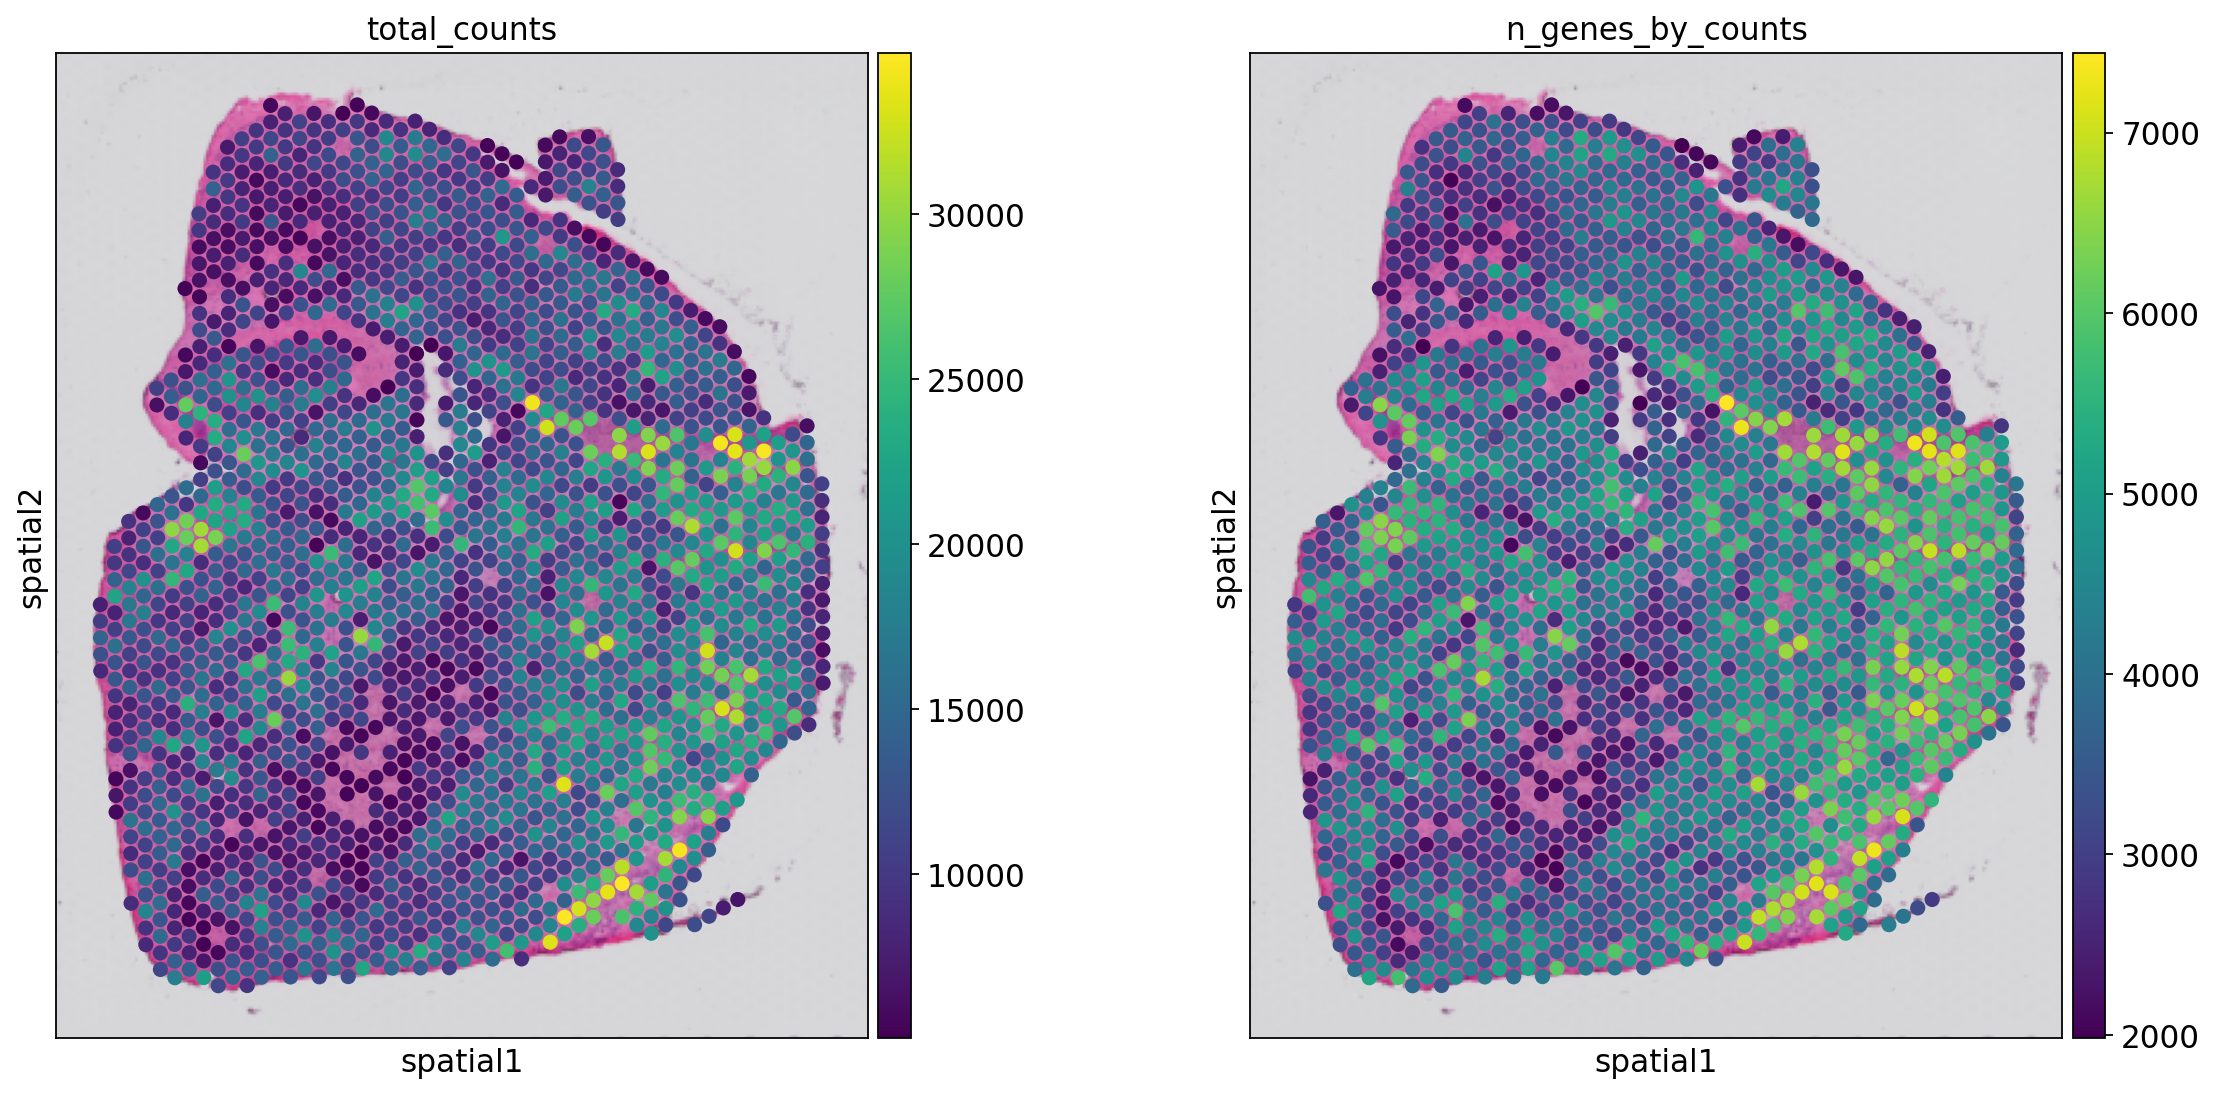

In [60]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="lowres", color=["total_counts", "n_genes_by_counts"], size=1.4)

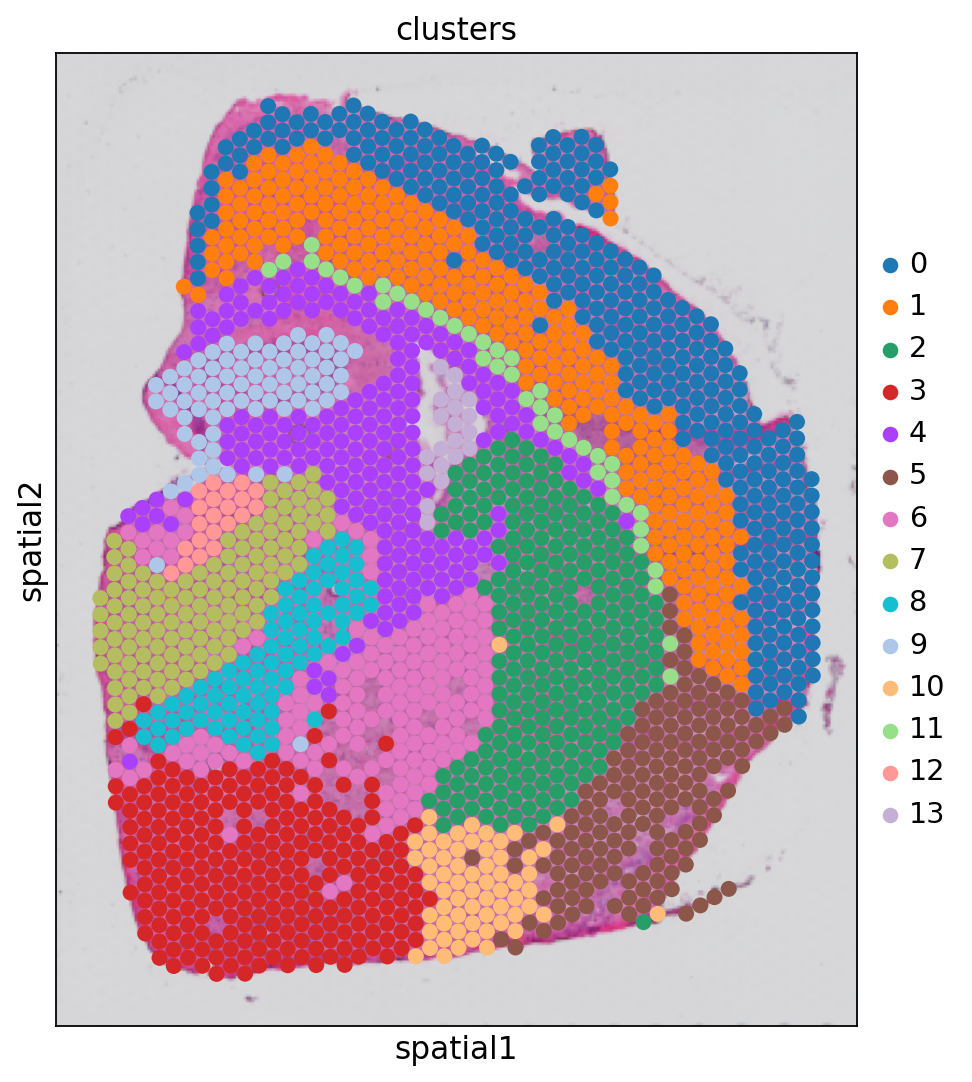

In [59]:
sc.pl.spatial(adata, img_key="lowres", color="clusters", size=1.5)

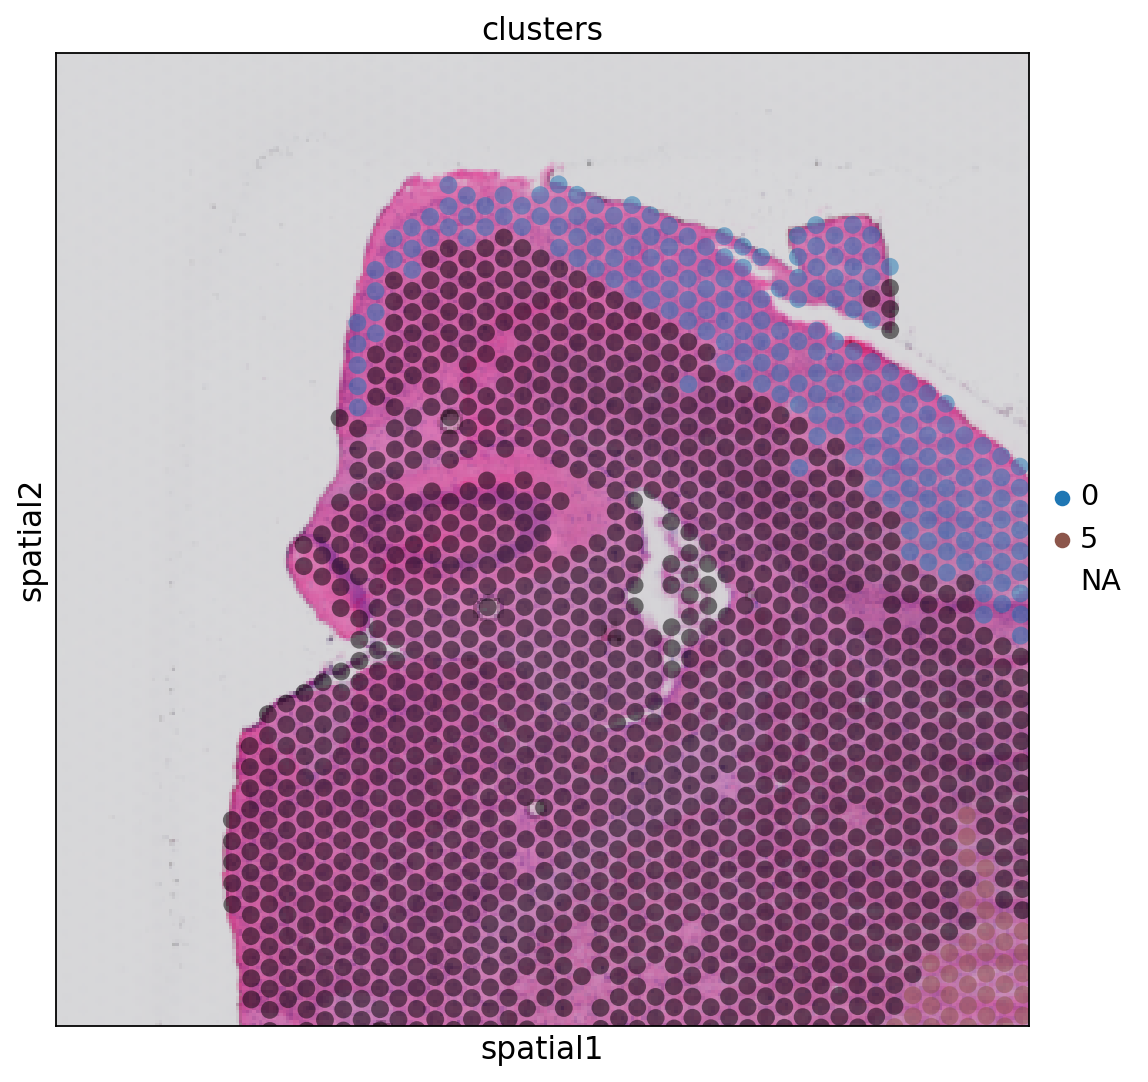

In [58]:
sc.pl.spatial(adata, img_key="lowres", color="clusters", groups=["0", "5"], crop_coord=[5000, 20000, 5000, 20000], alpha=0.5, size=1.3)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
categories: 0, 1, 2, etc.
var_group_labels: 0


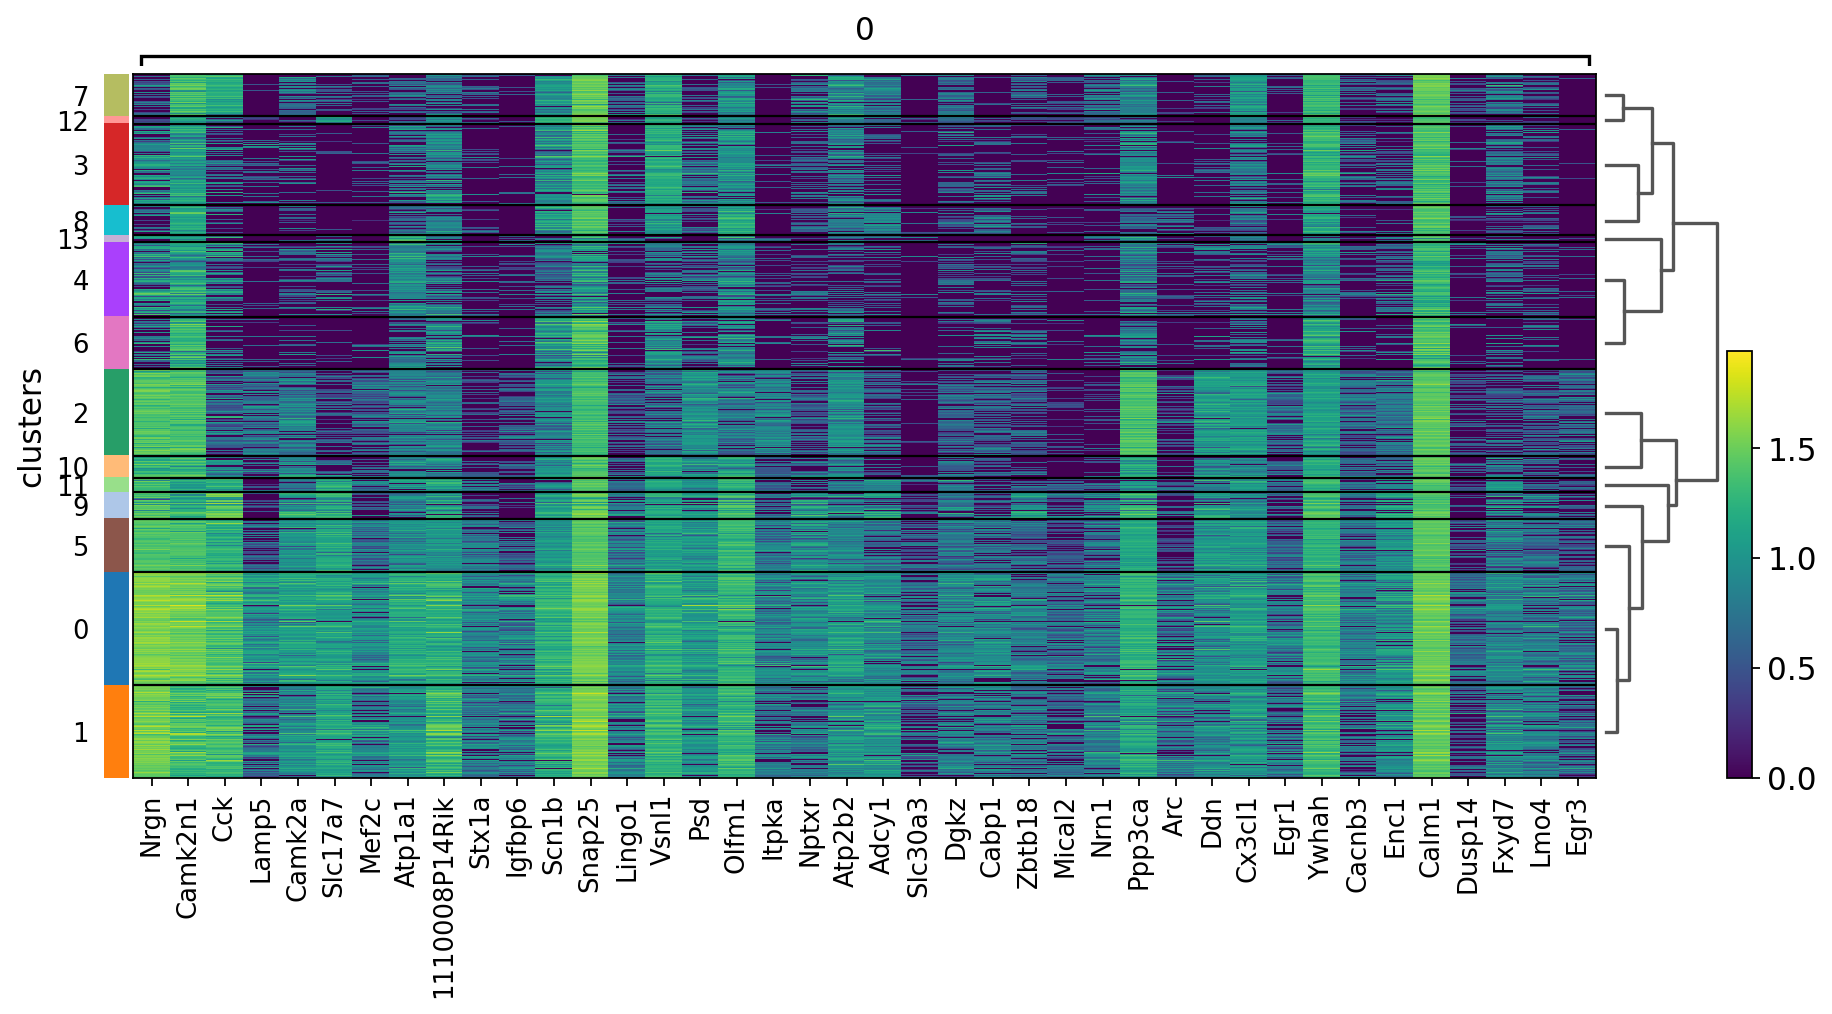

In [35]:
sc.tl.rank_genes_groups(adata, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(adata, groups="0", n_genes=40, groupby="clusters")

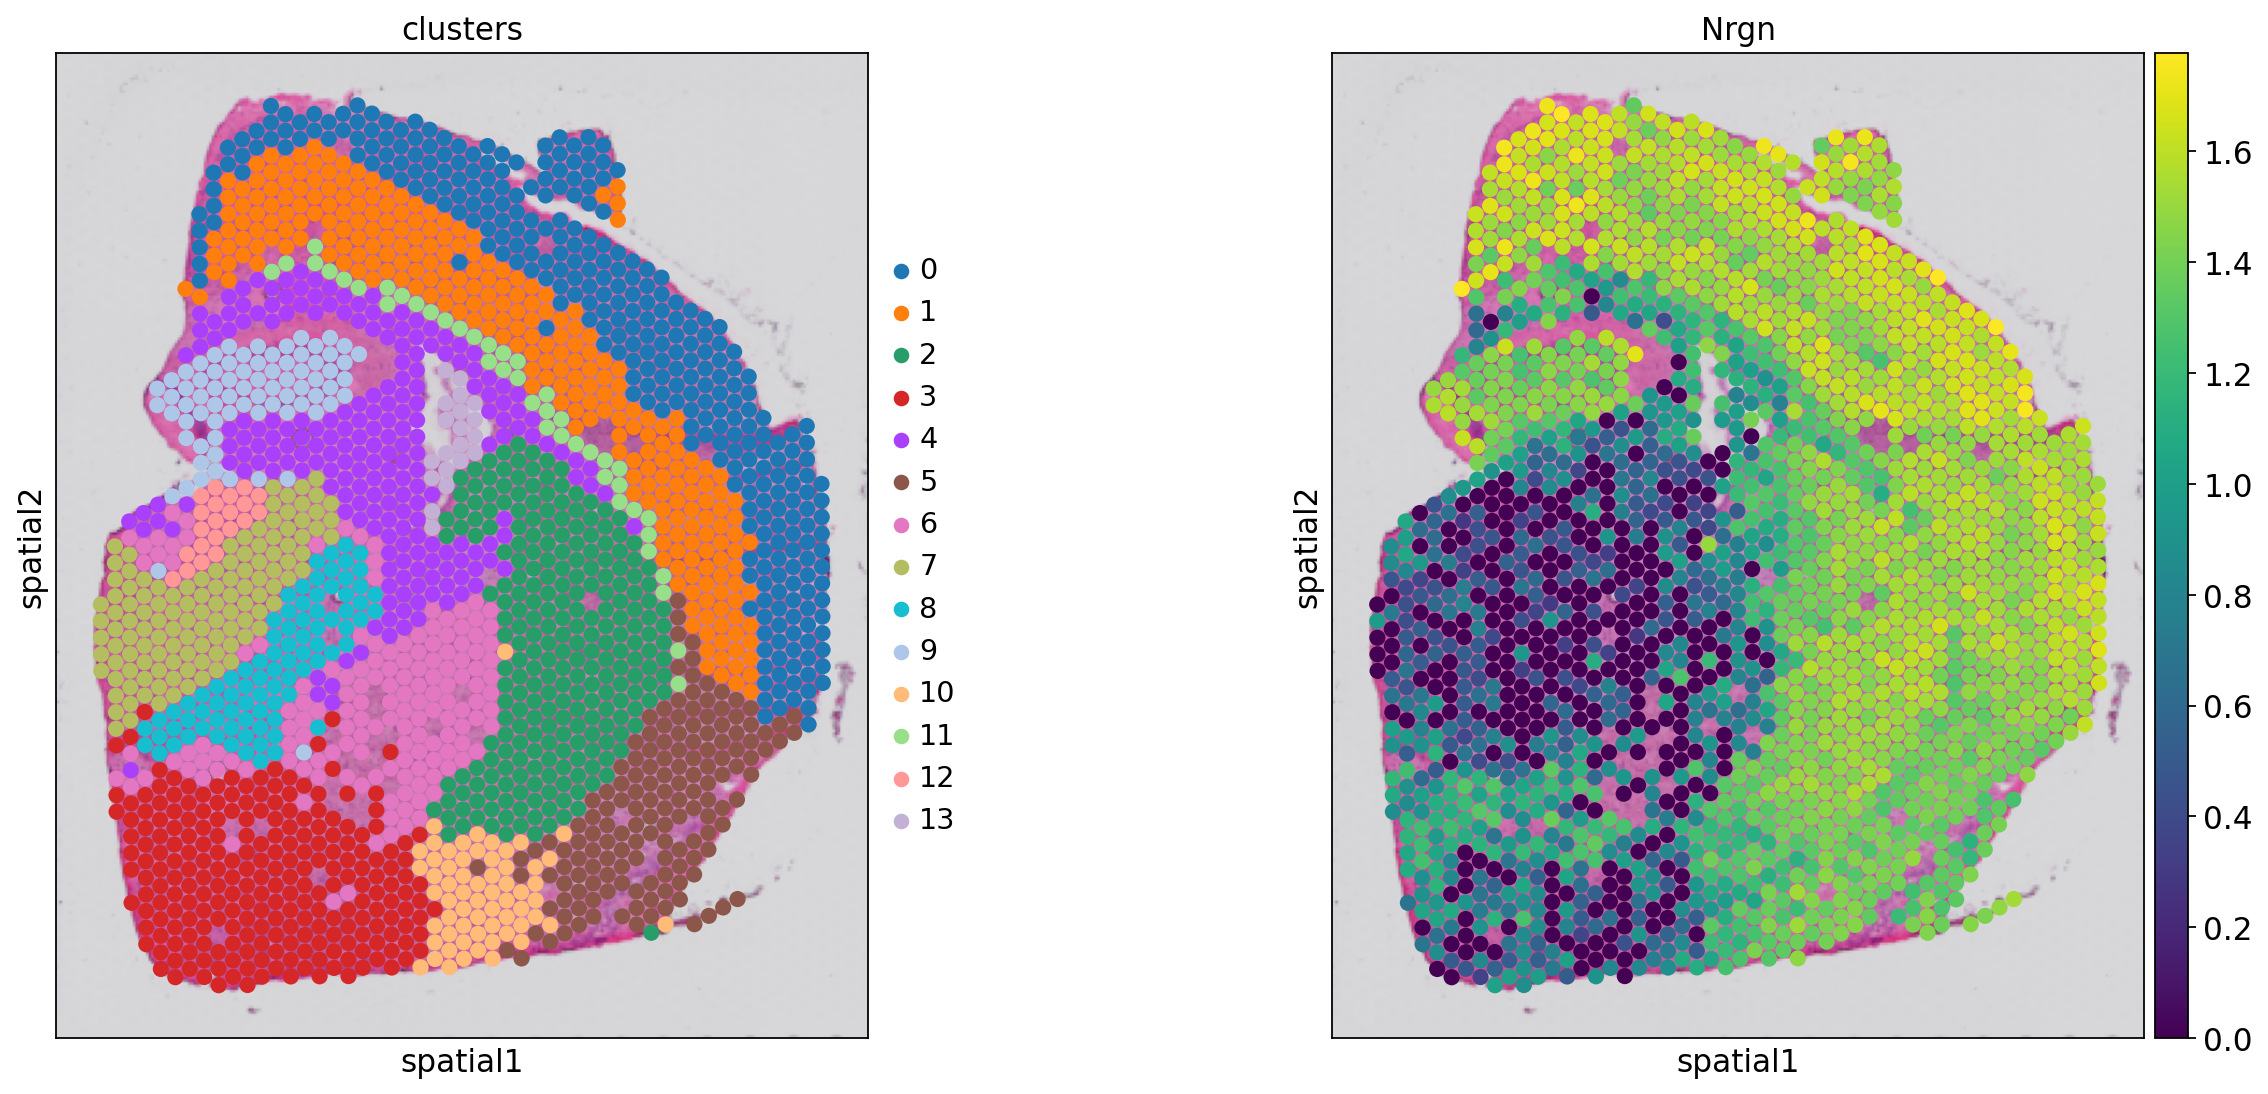

In [57]:
sc.pl.spatial(adata, img_key="lowres", color=["clusters", "Nrgn"], size= 1.5)

In [46]:
!pip install spatialde

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for NaiveDE: filename=NaiveDE-1.2.0-py3-none-any.whl size=5713 sha256=e3928386fdfd20a25dc49b934c81afcdf0afc84ada910952c2f5c7307e84fa1a
  Stored in directory: /home/mnoureld/.cache/pip/wheels/01/34/53/eff6dafc79c8f34e98fce9705fbcbc458461172e53adb65d16
Successfully built NaiveDE


In [47]:
# Identifying spatially variable genes using 'spatialde'
import SpatialDE

In [48]:
%%time
counts = pd.DataFrame(adata.X.todense(), columns=adata.var_names, index=adata.obs_names)
coord = pd.DataFrame(adata.obsm['spatial'], columns=['x_coord', 'y_coord'], index=adata.obs_names)
results = SpatialDE.run(coord, counts)

/home/mnoureld/.local/lib/python3.8/site-packages/SpatialDE/base.py:178: RuntimeWarning: divide by zero encountered in double_scalars
  s2_logdelta = 1. / (derivative(LL_obj, np.log(max_delta), n=2) ** 2)



CPU times: user 21min 21s, sys: 17min 14s, total: 38min 36s
Wall time: 9min 52s


In [49]:
results.index = results["g"]
adata.var = pd.concat([adata.var, results.loc[adata.var.index.values, :]], axis=1)

In [50]:
results.sort_values("qval").head(10)

FSV  M              g            l  max_delta  \
g                                                                   
2310002F09Rik  0.184076  4  2310002F09Rik   542.135629   4.394736   
Rasgrf1        0.196556  4        Rasgrf1   990.218715   3.973201   
Htr1b          0.175695  4          Htr1b   990.218715   4.560364   
Rab3b          0.258039  4          Rab3b  1808.649076   2.630150   
Rnf11          0.097227  4          Rnf11  1808.649076   8.493362   
Elavl4         0.176489  4         Elavl4  1808.649076   4.268135   
Myo6           0.200927  4           Myo6   990.218715   3.865624   
Eef1a1         0.487011  4         Eef1a1   990.218715   1.023860   
Cited4         0.128558  4         Cited4  1808.649076   6.200477   
Elovl5         0.169094  4         Elovl5   990.218715   4.776334   

                    max_ll  max_mu_hat  max_s2_t_hat model     n    s2_FSV  \
g                                                                            
2310002F09Rik  3227.443021    0.004306      0.000465    SE  2002  0.000015   
Rasgrf1        -594.725474    0.666662      0.032330    SE  2002  0.000031   
Htr1b           522.760656    0.074694      0.007107    SE  2002  0.000020   
Rab3b          -608.298512    0.323936      0.039225    SE  2002  0.000127   
Rnf11          -535.362193    0.744197      0.014915    SE  2002  0.000075   
Elavl4         -537.427597    0.321399      0.023050    SE  2002  0.000110   
Myo6           -700.969683    0.341668      0.029947    SE  2002  0.000055   
Eef1a1         1979.331747    1.480460      0.049480    SE  2002  0.000032   
Cited4          432.634072    0.099250      0.005947    SE  2002  0.000093   
Elovl5         -662.906507    0.320459      0.023718    SE  2002  0.000040   

               s2_logdelta      time          BIC  max_ll_null         LLR  \
g                                                                            
2310002F09Rik     0.000665  0.002937 -6424.478435  3146.738563   80.704459   
Rasgrf1           0.001220  0.003215  1219.858557  -772.752603  178.027129   
Htr1b             0.000934  0.002926 -1015.113704   329.594988  193.165668   
Rab3b             0.003673  0.002594  1247.004632  -855.360870  247.062358   
Rnf11             0.008449  0.003026  1101.131994  -608.098776   72.736583   
Elavl4            0.005072  0.002997  1105.262802  -706.706413  169.278816   
Myo6              0.002135  0.002920  1432.346975  -819.139165  118.169482   
Eef1a1            0.000597  0.002028 -3928.255886  1401.727268  577.604479   
Cited4            0.006775  0.002543  -834.860537   325.387226  107.246847   
Elovl5            0.001963  0.002936  1356.220622  -780.873756  117.967249   

               pval  qval  
g                          
2310002F09Rik   0.0   0.0  
Rasgrf1         0.0   0.0  
Htr1b           0.0   0.0  
Rab3b           0.0   0.0  
Rnf11           0.0   0.0  
Elavl4          0.0   0.0  
Myo6            0.0   0.0  
Eef1a1          0.0   0.0  
Cited4          0.0   0.0  
Elovl5          0.0   0.0

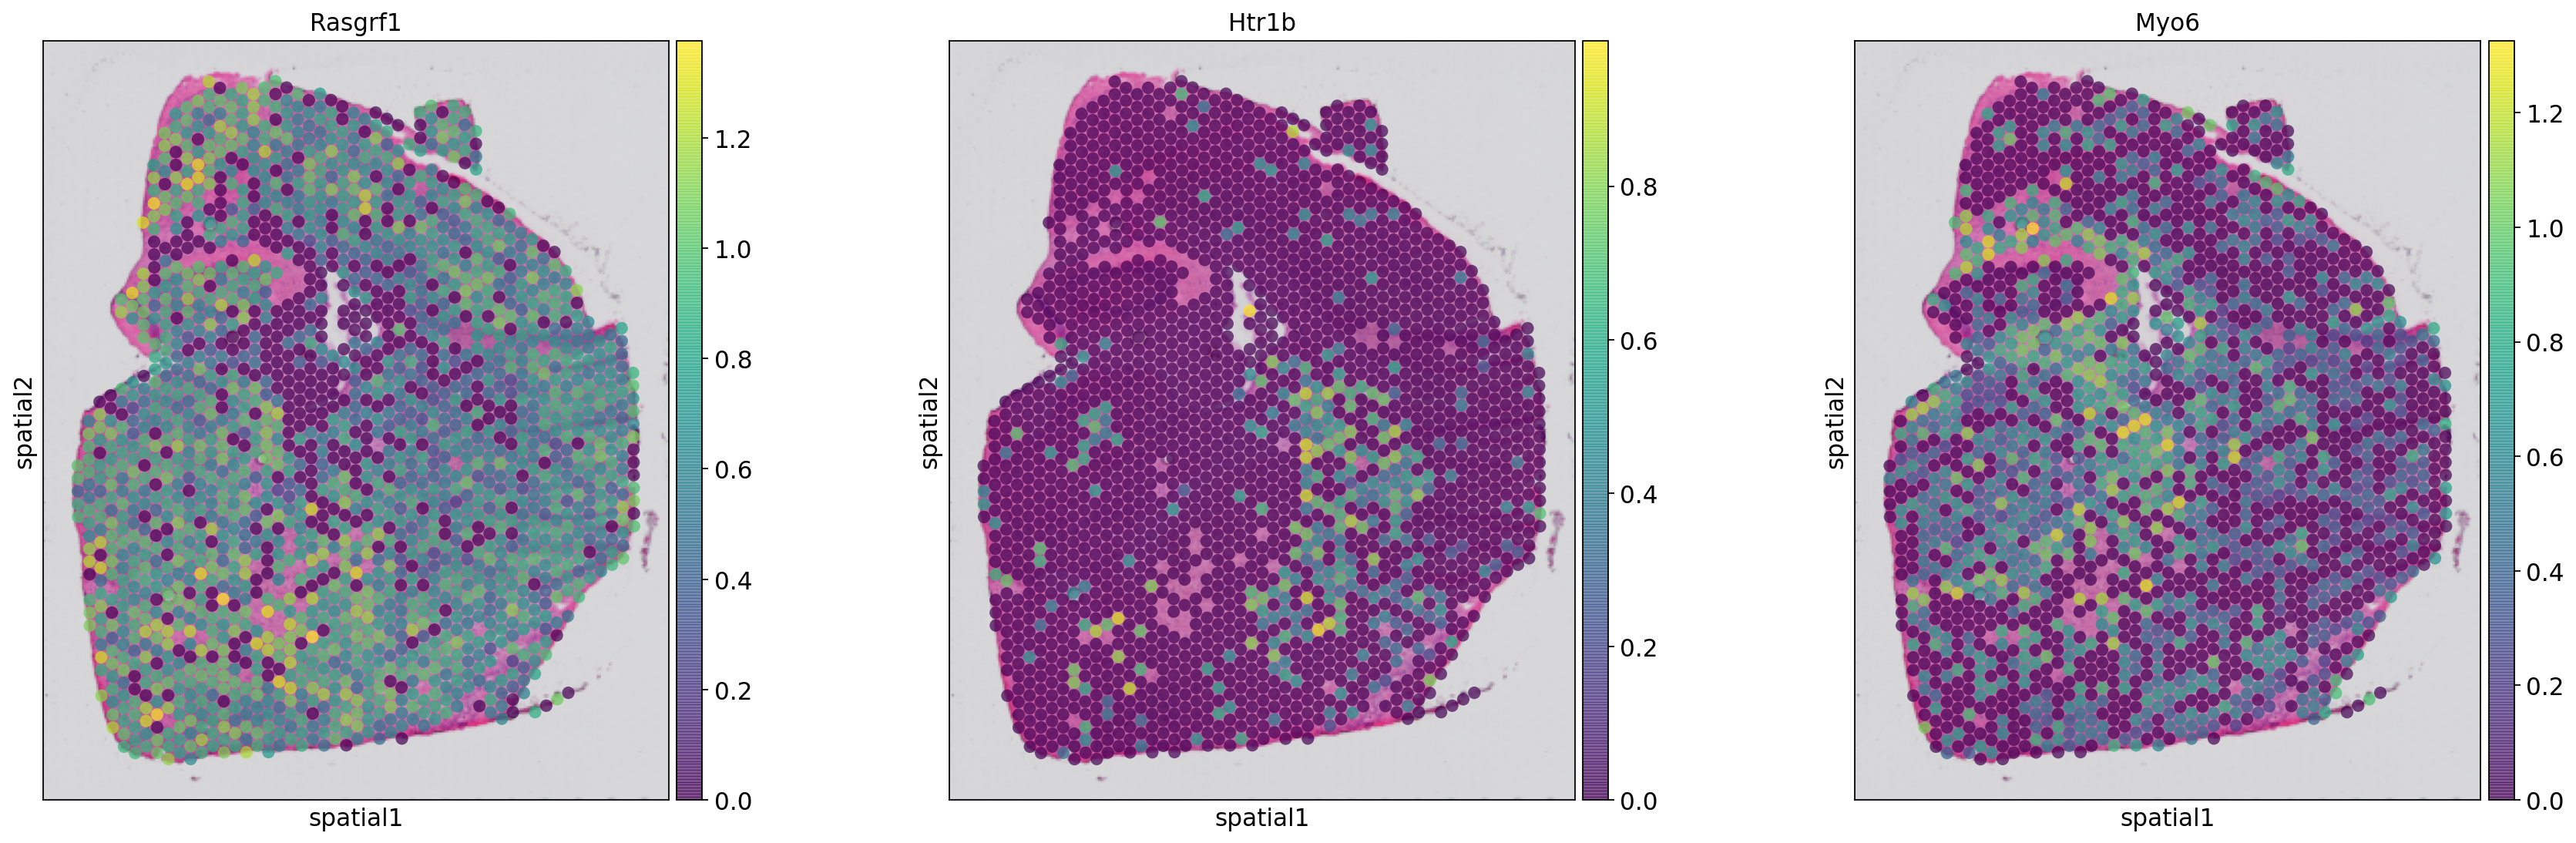

In [56]:
sc.pl.spatial(adata, img_key="lowres", color=["Rasgrf1", "Htr1b", "Myo6"], alpha=0.7, size=1.5)